ChemFind#Ver 1.1


In [4]:
from modules import function as fc
import PySimpleGUI as sg
from rdkit import Chem
import pubchempy as pcp
import csv
import pandas as pd

sg.theme("DarkBrown")


#官能基カウントのモジュールを空で実行し、官能基リストを作成
functional_names = fc.count_functional_groups().count.keys()

#記述子名のリスト
properties = ["Tag","ChemicalName","SMILES","MW (g/mol)","logP"]
#官能基名のリスト
functional_g = [f"{name} (mmol/g)" for name in functional_names]
#CSV出力用の２Dリスト
output_data = [properties+functional_g]


#過去データの取得、またはデータテーブルの初期化
try :
    past_tag = pd.read_csv("CSV/output.csv")["Tag"].tolist()
except:
    with open("CSV/output.csv", 'w',newline="") as file:
        writer = csv.writer(file)
        writer.writerow(output_data[0])
    past_tag = pd.read_csv("CSV/output.csv")["Tag"].tolist()


#全体のレイアウト
layout = [[sg.Text('ChemFind', font=('Constantia',20))],
          [sg.Frame("Main",[[sg.Text("Chemical Name or SMILES"),
                             sg.Input(size=(40, 1), key="-INPUT-"),
                             sg.Text("Tag"),
                             sg.Input(size=(10, 1),key = "Tag" )],
                            [sg.Radio('CAS or NAME',default=True, key="-1-", group_id='0'),
                             sg.Radio('SMILES',default=False, key="-2-", group_id='0')],
                            [sg.Text("Reaction")],
                            [sg.Checkbox("VinylPolymerize",key="polym", default=False)],
                            [sg.Checkbox("Acid Deprotonize",key="Acid_DH", default=False)],
                            [sg.Checkbox("Amine Protonize",key="Amine_H", default=False)], 
                            [sg.Button("Run",size=(10,1)),
                             sg.Button("Log",size=(10,1)),
                             sg.Push(),
                             sg.Button("Save",size=(10,1))],
                            [sg.Image(key="-IMAGE-")],
                            
                            [sg.Push(),sg.Button("Clear All Data",size=(15,1))],
                            [sg.Text("",size=(60, 1),key = "NAME")],
                            [sg.Text("",size=(60, 1),key = "SMILES")],
                            [sg.Text("",size=(60, 1),key = "MW")],
                            [sg.Text("",size=(60, 1),key = "LogP")]]), 
           #MainFrameの終了 / 出力テーブルの開始
           sg.Column(layout =[[sg.Text("",size=(20,1),key=name),
                              sg.Text("", key=f"{name}_")] for name in functional_names]),
           sg.Table(headings =["Tag Name"],values = [[elem] for elem in past_tag],
                    key ="output_table",
                    size=(10,30))
           ]]


# ウインドウの出現位置を指定
win_location = (0, 0)
window = sg.Window("ChemFind", layout,resizable=True,location=win_location)


while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED or event == "Cancel":
        break
    if event == "Run":
        try:
                
            if values['-1-'] == True:
    
                input_val = values["-INPUT-"]
                results = pcp.get_compounds(input_val, 'name')
                compound = results[0]
                smiles = compound.canonical_smiles
                      
    
            elif values['-2-'] == True:
                
                input_val = values["-INPUT-"]
                iupac_name = "-" 
                smiles = input_val
    
            #化学反応
            
            if values["polym"] == True:
                smiles = fc.polym(smiles)
    
            if values["Acid_DH"] == True:
                smiles = fc.acid_takeHs(smiles)
    
            if values["Amine_H"] == True:
                smiles = fc.amine_addHs(smiles)                
    
    
                      
            #smilesから官能基個数のカウントモジュール実行
            fg = fc.count_functional_groups(smiles)
    
            # 画像をウィンドウ内のsg.Imageコンポーネントに更新
            window["-IMAGE-"].update("images/mol_structure.png")
            window["MW"].update(f"MW : {fg.mw} g/mol")
            window["LogP"].update(f"LogP : {fg.logP}")
            window["SMILES"].update(f"SMILES : {smiles}")
    
            for name in functional_names:
                window[name].update(f"{name} : {fg.count[name]}count")
                window[f"{name}_"].update(f"{round(1000*fg.count[name]/fg.mw,2)}mmol/g")
                
        except:
            print("something wrong!")

    #output.csvの中身のTagリストを取得

    if event == "Log":
        #追加データ行の作製
        tag = values["Tag"]
        chemical_name = values["-INPUT-"]
        new_row = [tag,chemical_name,smiles,fg.mw,fg.logP]+[1000*fg.count[name]/fg.mw for name in functional_names]
        #過去のTag名重複チェッカ－
        past_tag2 = past_tag + [row[0] for row in output_data][1:]
        if tag in past_tag2:
            sg.popup("AlreadyExist",auto_close=True,auto_close_duration=1)
        else:
            output_data.append(new_row)
            #過去Tagデータの更新
            past_tag2 = past_tag + [f"** {row[0]}" for row in output_data][1:]
            #Windowテーブルの更新
            window["output_table"].update([[elem] for elem in past_tag2])
            
    if event == "Save":                  
        with open("CSV/output.csv", mode="a", newline="") as file:
            writer = csv.writer(file)
            for row in output_data[1:]:
                writer.writerow(row)
        window.close()

    if event == "Clear All Data":
        output_data = [properties+functional_g]
        with open("CSV/output.csv", 'w',newline="") as file:
            writer = csv.writer(file)
            writer.writerow(output_data[0])
        past_tag = pd.read_csv("CSV/output.csv")["Tag"].tolist()
        past_tag2 = past_tag + [row[0] for row in output_data][1:]
        window["output_table"].update([[elem] for elem in past_tag2])


window.close()


fg = fc.count_functional_groups(smiles)

Installser.py

In [4]:
import subprocess

# パッケージのリストを指定してpip installを実行する
package_list = ['pubchempy', 'PySimpleGUI', 'rdkit','py3Dmol']
subprocess.run(['pip', 'install'] + package_list)

import pkg_resources

def is_package_installed(package_name):
    try:
        pkg_resources.get_distribution(package_name)
        return True
    except pkg_resources.DistributionNotFound:
        return False

# パッケージ名を指定して確認する
checker = True

for package_name in  package_list:

    if is_package_installed(package_name):
        print(f"{package_name} finished")
        checker = checker*True
    else:
        print(f"{package_name} error")
        checker = checker*False

if checker ==True:
    print("■■        ■■        ■")
    print(" ■   ■■   ■         ■")
    print(" ■   ■■   ■   ■■■   ■    ■■■■  ■■■■   ■■■■■■■■    ■■■")
    print(" ■   ■■   ■  ■■  ■  ■   ■■    ■■  ■   ■   ■   ■  ■■  ■")
    print(" ■■ ■■ ■  ■  ■   ■■ ■   ■     ■    ■  ■   ■   ■  ■   ■■")
    print(" ■■ ■  ■ ■■  ■■■■■■ ■   ■     ■    ■  ■   ■   ■  ■■■■■■")
    print("  ■ ■  ■ ■   ■      ■   ■     ■    ■  ■   ■   ■  ■     ")
    print("  ■■    ■■   ■■     ■   ■■    ■■  ■   ■   ■   ■  ■■    ")
    print("  ■■    ■■    ■■■■   ■   ■■■■  ■■■■   ■   ■   ■   ■■■■ ")
import time
# 5秒間待機
time.sleep(10)

pubchempy finished
PySimpleGUI finished
rdkit finished
py3Dmol finished
■■        ■■        ■
 ■   ■■   ■         ■
 ■   ■■   ■   ■■■   ■    ■■■■  ■■■■   ■■■■■■■■    ■■■
 ■   ■■   ■  ■■  ■  ■   ■■    ■■  ■   ■   ■   ■  ■■  ■
 ■■ ■■ ■  ■  ■   ■■ ■   ■     ■    ■  ■   ■   ■  ■   ■■
 ■■ ■  ■ ■■  ■■■■■■ ■   ■     ■    ■  ■   ■   ■  ■■■■■■
  ■ ■  ■ ■   ■      ■   ■     ■    ■  ■   ■   ■  ■     
  ■■    ■■   ■■     ■   ■■    ■■  ■   ■   ■   ■  ■■    
  ■■    ■■    ■■■■   ■   ■■■■  ■■■■   ■   ■   ■   ■■■■ 


Reaction


In [31]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem

#esterificattion of ethanol and acetic acid
reactant1 = "CCO"
reactant2 = "CCC(=O)O"


rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])O.[O:3][C:4]>>[C:1](=[O:2])[O:3][C:4]')
reacts1 = (Chem.MolFromSmiles(reactant1),Chem.MolFromSmiles(reactant2))
reacts2 = (Chem.MolFromSmiles(reactant2),Chem.MolFromSmiles(reactant1))

products = rxn.RunReactants(reacts1)+rxn.RunReactants(reacts2)

In [32]:
products

((<rdkit.Chem.rdchem.Mol at 0x1a9ec002040>,),)

In [22]:
Chem.MolToSmiles(products[0][0])

'CCOC(=O)CC'

In [43]:
def reaction_ester(acid,alcohol):
    rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])O.[O:3][C:4]>>[C:1](=[O:2])[O:3][C:4]')
    reacts = (Chem.MolFromSmiles(acid),Chem.MolFromSmiles(alcohol))
    products = rxn.RunReactants(reacts)
    return Chem.MolToSmiles(products[0][0])

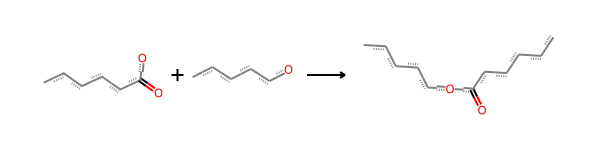

In [49]:
#esterificattion of ethanol and acetic acid
alcohol = "CCCCCO"
acid = "CCCCCC(=O)O"
product = reaction_ester(acid,alcohol)
AllChem.ReactionFromSmarts(f"{acid}.{alcohol}>>{product}")

In [72]:
def Nt_amine_acid(acid,amine):
    rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])[O:3].[N:4]>>[C:1](=[O:2])[O-:3].[N+:4]')
    reacts = (Chem.MolFromSmiles(acid),Chem.MolFromSmiles(amine))
    products = rxn.RunReactants(reacts)
    return [Chem.MolToSmiles(x) for x in products[0]]

In [79]:
#esterificattion of ethanol and acetic acid
amine = "CCCCCN(C)C"
acid = "CCCCCC(=O)O"
product = Nt_amine_acid(acid,amine)

In [80]:
product

['CCCCCC(=O)[O-]', 'CCCCC[NH+](C)C']